In [13]:
import importlib
import warnings
warnings.filterwarnings("ignore")

import os
current_directory = os.getcwd()
print(current_directory)

import time
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from jupyterthemes import jtplot
jtplot.style(theme="monokai", context="notebook", ticks=True, grid=True)
import seaborn as sns

%load_ext autoreload
%autoreload 2

/home/lucy/Documents/MachineLearning/HateSpeech
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
train_df = pd.read_csv('./DataSet/train_E6oV3lV.csv', index_col=0)
train_df

,label,tweet
id,,
1,0,@user when a father is dysfunctional and is s...
2,0,@user @user thanks for #lyft credit i can't us...
3,0,bihday your majesty
4,0,#model i love u take with u all the time in ...
5,0,factsguide: society now #motivation
...,...,...
31958,0,ate @user isz that youuu?ðððððð...
31959,0,to see nina turner on the airwaves trying to...
31960,0,listening to sad songs on a monday morning otw...


In [15]:
print('Unique labels:', train_df.label.unique())
print('')
print('Summary:', train_df.info())
print('')
print('Number of unique values: ', train_df.label.isnull().sum())
print('')
print('Number of values: ', train_df.label.value_counts())

Unique labels: [0 1]

<class 'pandas.core.frame.DataFrame'>
Index: 31962 entries, 1 to 31962
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   31962 non-null  int64 
 1   tweet   31962 non-null  object
dtypes: int64(1), object(1)
memory usage: 749.1+ KB
Summary: None

Number of unique values:  0

Number of values:  label
0    29720
1     2242
Name: count, dtype: int64


In [16]:
train_df['tweet'] = train_df['tweet'].astype('string')
train_df.tweet.info()

<class 'pandas.core.series.Series'>
Index: 31962 entries, 1 to 31962
Series name: tweet
Non-Null Count  Dtype 
--------------  ----- 
31962 non-null  string
dtypes: string(1)
memory usage: 499.4 KB


In [18]:
import pandas as pd
import re
from html import unescape
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import numpy as np

# Load the dataset
train_df = pd.read_csv('./DataSet/train_E6oV3lV.csv', index_col=0)

# Ensure the text data does not contain any NaN values
train_df['tweet'] = train_df['tweet'].fillna('')
train_texts = train_df['tweet'].tolist()  # Your training texts
train_labels = train_df['label'].tolist()  # Your training labels

class AbstractProcessor:
    def __init__(self):
        self.default_patterns = [
            r'\$\$',  # Specific special characters
            r'\^',  # Specific special characters
            r'\$[^$]*?\$',  # Inline math expressions enclosed in $
            r'\\[a-zA-Z]+\{.*?\}',  # LaTeX commands
            r'\w+_{[^}]+}',  # Subscripts
            r"(?<!\w)'(?!\w)",  # Primes that do not follow or precede word characters
            r'\w+_{[^}]+}\'?',  # Subscripts followed by an optional prime
            r'\w+^{-?\d+}',  # Superscripts
        ]

    def clean_text(self, text):
        # Unescape HTML entities and normalize text first
        text = unescape(text.replace('\n', ' '))

        # Specific substitution to handle escaped apostrophes and middle initials
        text = re.sub(r"\\'", '', text)  # Remove escaped apostrophes
        text = re.sub(r'\.-', '.', text)  # Correct middle initial formatting if necessary

        # Replace math expressions and LaTeX commands
        for pattern in self.default_patterns:
            text = re.sub(pattern, ' [MATH_EXPR] ', text)

        # Normalize whitespace after replacements by replacing newlines with
        # spaces and removing excessive whitespace.
        text = re.sub(r'\s+', ' ', text).strip()
        return text

    def replace_math_expressions(self, text):
        replacement = ' [MATH_EXPR] '
        for pattern in self.default_patterns:
            text = re.sub(pattern, replacement, text)
        text = re.sub(r'(\s*\[MATH_EXPR\]\s*)+', ' [MATH_EXPR] ', text)
        return text

    def find_special_signs(self, col, patterns=None):
        if patterns is None:
            patterns = self.default_patterns
        special_signs = set()
        if isinstance(col, pd.Series):  # Check if the input is a Series
            for text in col:
                for pattern in patterns:
                    matches = re.findall(pattern, text)
                    special_signs.update(matches)
        else:
            for pattern in patterns:
                matches = re.findall(pattern, col)  # This assumes 'col' is a single string
                special_signs.update(matches)
        return special_signs

    def process(self, series, func=None):
        if func:
            return series.apply(func)
        else:
            return series.apply(self.clean_text)

    def analyze_columns(self, dataframe, columns):
        special_signs_by_column = {}
        for column in columns:
            results = self.process(dataframe[column], lambda x: self.find_special_signs(x))
            column_signs = set()
            for result in results:
                column_signs.update(result)
            special_signs_by_column[column] = column_signs
        return special_signs_by_column

    def find_and_clean_special_signs(self, text):
        special_signs = self.find_special_signs(text)
        cleaned_text = self.clean_text(text)
        return cleaned_text

class TweetProcessor(AbstractProcessor):
    '''Adds methods tailored to the unique characteristics of tweets, such as removing @user mentions,
    hashtags, and URLs.'''
    def __init__(self):
        super().__init__()
        self.tweet_patterns = [
            r'@\w+',  # Remove @user mentions
            r'http\S+|www\S+',  # Remove URLs
        ]

    def clean_tweet(self, text):
        text = unescape(text.replace('\n', ' '))
        for pattern in self.tweet_patterns:
            text = re.sub(pattern, '', text)

        text = re.sub(r'\$', '', text)  # Remove all dollar signs
        text = re.sub(r'\^', '', text)  # Remove all caret symbols
        text = re.sub(r'\'', '', text)  # Remove all single quotes
        text = re.sub(r'\[([^\]]+)\]', r'\1', text)  # Remove square brackets but keep content
        text = re.sub(r'\{([^}]+)\}', r'\1', text)  # Remove curly braces but keep content
        text = re.sub(r'[^\x00-\x7F]+', '', text)  # Remove non-ASCII characters (e.g., emojis)
        text = re.sub(r'\s+', ' ', text).strip()
        return text

    def clean_special_characters(self, text):
        '''Focuses on removing special characters while preserving surrounding text.'''
        text = unescape(text.replace('\n', ' '))
        text = re.sub(r'\$', '', text)  # Remove all dollar signs
        text = re.sub(r'\^', '', text)  # Remove all caret symbols
        text = re.sub(r'\'', '', text)  # Remove all single quotes
        text = re.sub(r'[^\x00-\x7F]+', '', text)  # Remove non-ASCII characters
        text = re.sub(r'@\w+', '', text)  # Remove @user mentions
        text = re.sub(r'#(\w+)', r'\1', text)  # Remove hashtags but keep content
        text = re.sub(r'[~:.,!]+', '', text)
        return text.strip()

    def process(self, series, func=None):
        if func:
            return series.apply(func)
        else:
            return series.apply(self.clean_special_characters)

# Instantiate and use the TweetProcessor
processor = TweetProcessor()
cleaned_tweets = processor.process(train_df['tweet'])

# Display cleaned tweets
print(cleaned_tweets.head())

id
1    when a father is dysfunctional and is so selfi...
2    thanks for lyft credit i cant use cause they d...
3                                  bihday your majesty
4      model   i love u take with u all the time in ur
5                 factsguide society now    motivation
Name: tweet, dtype: object


### Featurization in NLP

Featurization is the process of converting text data into numerical representations that machine learning models can interpret. This step is crucial in NLP (Natural Language Processing) because models require numerical input to perform tasks such as classification, clustering, and sentiment analysis. In this context, three different featurization techniques were utilized: Bag of Words (BoW), TF-IDF, and Word Embeddings using GloVe.

1. **Bag of Words (BoW)**: This method converts text into a fixed-size vector by counting the occurrences of each word in the text. Each dimension of the vector represents a specific word from the vocabulary, and the value indicates the word's frequency in the document. BoW is simple and efficient, especially for text classification tasks, but it ignores the semantic meaning and context of words.

2. **TF-IDF (Term Frequency-Inverse Document Frequency)**: TF-IDF improves upon BoW by considering not only the frequency of a word in a document (term frequency) but also how unique or common the word is across all documents (inverse document frequency). This method helps to down-weight common words and highlight more informative words. TF-IDF is useful when distinguishing important words in large corpora and is often preferred for tasks where capturing the importance of terms is crucial.

3. **Word Embeddings (e.g., GloVe)**: Word embeddings represent words in a dense vector space where semantically similar words are closer together. Pre-trained embeddings like GloVe capture the context of words in a corpus by considering word co-occurrence statistics. This method retains semantic relationships and is particularly beneficial for tasks that require understanding the meaning and context of words, such as sentiment analysis and language translation. Unlike BoW and TF-IDF, word embeddings are more effective in generalizing across different contexts and handling large vocabularies.

4. **Sentence Embeddings (e.g., BERT)**: Sentence transformers like BERT provide embeddings that are context-aware and capture the meaning of sentences. BERT embeddings are generated by processing text through deep learning models that consider the surrounding context of each word, resulting in rich, contextual representations. These embeddings are useful for tasks that require understanding the nuanced meaning and context of text, such as named entity recognition and question answering.

5. **Embeddings from GPT**: GPT models generate embeddings that capture the sequential nature of text by predicting the next word in a sentence. GPT embeddings are also context-aware, but they emphasize the generative aspect of language, making them suitable for tasks like text generation, completion, and conversational agents.

### Key Differences Between Sentence Embeddings (BERT) and GPT Embeddings

- **Contextual Awareness**: Both BERT and GPT embeddings are context-aware, meaning they capture the meaning of words based on their context within a sentence. However, BERT embeddings are bidirectional, considering both the left and right context of a word, while GPT embeddings are unidirectional, considering only the left context.
  
- **Training Objectives**: BERT is trained using a masked language model (MLM) objective, where some words in the input are masked and the model learns to predict them. This allows BERT to capture deep contextual relationships. GPT, on the other hand, is trained using a causal language model (CLM) objective, focusing on predicting the next word in a sequence, which is effective for generative tasks.

- **Use Cases**: BERT embeddings are particularly useful for tasks that require a deep understanding of the text context, such as sentiment analysis, question answering, and named entity recognition. GPT embeddings excel in tasks that involve text generation, dialogue systems, and any application where predicting the next word is crucial.



In [20]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import gensim.downloader as api
import torch
from transformers import BertTokenizer, BertModel, GPT2Tokenizer, GPT2Model
import joblib

# Create directory to save embeddings if it doesn't exist
os.makedirs('./Embeddings', exist_ok=True)

# Bag of Words (BoW) Featurization
vectorizer_bow = CountVectorizer()
X_bow = vectorizer_bow.fit_transform(cleaned_tweets)

# Save BoW
joblib.dump(X_bow, './Embeddings/X_bow.pkl')
joblib.dump(vectorizer_bow, './Embeddings/vectorizer_bow.pkl')

# TF-IDF Featurization
vectorizer_tfidf = TfidfVectorizer()
X_tfidf = vectorizer_tfidf.fit_transform(cleaned_tweets)

# Save TF-IDF
joblib.dump(X_tfidf, './Embeddings/X_tfidf.pkl')
joblib.dump(vectorizer_tfidf, './Embeddings/vectorizer_tfidf.pkl')

# Word Embeddings (GloVe) Featurization
glove_model = api.load("glove-twitter-25")

def get_average_word2vec(tokens_list, vector, generate_missing=False, k=25):
    if len(tokens_list) < 1:
        return np.zeros(k)
    vectorized = [vector[word] if word in vector else np.zeros(k) for word in tokens_list]
    length = len(vectorized)
    summed = np.sum(vectorized, axis=0)
    averaged = np.divide(summed, length)
    return averaged

def get_word2vec_embeddings(texts, model, generate_missing=False):
    embeddings = texts.apply(lambda x: get_average_word2vec(x.split(), model))
    return np.array(embeddings.tolist())

X_glove = get_word2vec_embeddings(pd.Series(cleaned_tweets), glove_model)

# Save GloVe embeddings
np.save('./Embeddings/X_glove.npy', X_glove)

# Display feature representations shapes
print("BoW Feature Representation Shape:", X_bow.shape)
print("TF-IDF Feature Representation Shape:", X_tfidf.shape)
print("Word Embeddings (GloVe) Feature Representation Shape:", X_glove.shape)

# Check for CUDA availability
print("CUDA available: ", torch.cuda.is_available())
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Embeddings from pre-trained semantic transformer (BERT)
tokenizer_bert = BertTokenizer.from_pretrained('bert-base-uncased')
model_bert = BertModel.from_pretrained('bert-base-uncased')
model_bert.to(device)

def get_bert_embeddings(texts, tokenizer, model, device):
    embeddings = []
    for text in texts:
        inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512).to(device)
        outputs = model(**inputs)
        embeddings.append(outputs.last_hidden_state.mean(dim=1).detach().cpu().numpy())
    return np.vstack(embeddings)

X_bert = get_bert_embeddings(cleaned_tweets, tokenizer_bert, model_bert, device)

# Save BERT embeddings
np.save('./Embeddings/X_bert.npy', X_bert)

print("BERT Feature Representation Shape:", X_bert.shape)

# # Embeddings from pre-trained GPT
# tokenizer_gpt = GPT2Tokenizer.from_pretrained('gpt2')
# model_gpt = GPT2Model.from_pretrained('gpt2')
# model_gpt.to(device)

# def get_gpt_embeddings(texts, tokenizer, model, device):
#     embeddings = []
#     for text in texts:
#         inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512).to(device)
#         outputs = model(**inputs)
#         embeddings.append(outputs.last_hidden_state.mean(dim=1).detach().cpu().numpy())
#     return np.vstack(embeddings)

# X_gpt = get_gpt_embeddings(cleaned_tweets, tokenizer_gpt, model_gpt, device)

# # Save GPT embeddings
# np.save('./Embeddings/X_gpt.npy', X_gpt)

# print("GPT Feature Representation Shape:", X_gpt.shape)

# Loading the saved embeddings
X_bow_loaded = joblib.load('./Embeddings/X_bow.pkl')
vectorizer_bow_loaded = joblib.load('./Embeddings/vectorizer_bow.pkl')
X_tfidf_loaded = joblib.load('./Embeddings/X_tfidf.pkl')
vectorizer_tfidf_loaded = joblib.load('./Embeddings/vectorizer_tfidf.pkl')
X_glove_loaded = np.load('./Embeddings/X_glove.npy')
X_bert_loaded = np.load('./Embeddings/X_bert.npy')
#X_gpt_loaded = np.load('./Embeddings/X_gpt.npy')

# Verify loaded data shapes
print("Loaded BoW Feature Representation Shape:", X_bow_loaded.shape)
print("Loaded TF-IDF Feature Representation Shape:", X_tfidf_loaded.shape)
print("Loaded Word Embeddings (GloVe) Feature Representation Shape:", X_glove_loaded.shape)
print("Loaded BERT Feature Representation Shape:", X_bert_loaded.shape)
#print("Loaded GPT Feature Representation Shape:", X_gpt_loaded.shape)

BoW Feature Representation Shape: (31962, 40744)
TF-IDF Feature Representation Shape: (31962, 40744)
Word Embeddings (GloVe) Feature Representation Shape: (31962, 25)
CUDA available:  True
BERT Feature Representation Shape: (31962, 768)
Loaded BoW Feature Representation Shape: (31962, 40744)
Loaded TF-IDF Feature Representation Shape: (31962, 40744)
Loaded Word Embeddings (GloVe) Feature Representation Shape: (31962, 25)
Loaded BERT Feature Representation Shape: (31962, 768)


### Interpretation of Feature Representations

1. **BoW Feature Representation Shape: (31962, 40744)**:
   - **Explanation**: The Bag of Words (BoW) method has converted the 31,962 tweets into vectors of size 40,744. This means there are 40,744 unique words (or tokens) across all tweets in the dataset. Each tweet is represented as a sparse vector indicating the frequency of each word.
   - **Use Case**: BoW is useful for text classification tasks where word frequency is important. However, it does not capture the context or semantics of the words.

2. **TF-IDF Feature Representation Shape: (31962, 40744)**:
   - **Explanation**: Similar to BoW, the TF-IDF method also produced vectors of size 40,744 for each of the 31,962 tweets. TF-IDF adds weights to the words based on their frequency across all documents, highlighting important words and down-weighting common ones.
   - **Use Case**: TF-IDF is preferred when identifying the importance of words within documents, making it suitable for tasks like document clustering and keyword extraction.

3. **Word Embeddings (GloVe) Feature Representation Shape: (31962, 25)**:
   - **Explanation**: Using GloVe embeddings, each of the 31,962 tweets is represented as a dense vector of size 25. These embeddings capture semantic relationships between words, with similar words having similar vectors.
   - **Use Case**: GloVe embeddings are useful for tasks requiring semantic understanding, such as sentiment analysis and text similarity.

4. **CUDA available: True**:
   - **Explanation**: CUDA is available, meaning a GPU is accessible for computation. This is beneficial for processing large models like BERT and GPT, as it significantly speeds up the computation.

5. **BERT Feature Representation Shape: (31962, 768)**:
   - **Explanation**: BERT has generated embeddings of size 768 for each of the 31,962 tweets. These embeddings are context-aware, meaning the same word can have different embeddings based on its context within the tweet.
   - **Use Case**: BERT embeddings are ideal for advanced NLP tasks that require understanding the context and nuances of language, such as named entity recognition, question answering, and sentiment analysis.

6. **Loaded BoW Feature Representation Shape: (31962, 40744)**:
   - **Explanation**: The BoW feature representation was successfully loaded, maintaining the shape of (31,962, 40,744). This indicates that the data was correctly saved and reloaded without any loss.

7. **Loaded TF-IDF Feature Representation Shape: (31962, 40744)**:
   - **Explanation**: The TF-IDF feature representation was successfully loaded, maintaining the shape of (31,962, 40,744). This confirms that the data integrity was preserved during the save and load process.

8. **Loaded Word Embeddings (GloVe) Feature Representation Shape: (31962, 25)**:
   - **Explanation**: The GloVe embeddings were successfully loaded, preserving the shape of (31,962, 25). This ensures that the semantic relationships captured by GloVe were retained.

9. **Loaded BERT Feature Representation Shape: (31962, 768)**:
   - **Explanation**: The BERT embeddings were successfully loaded, retaining the shape of (31,962, 768). This confirms that the context-aware embeddings were accurately saved and reloaded.

### Summary

The different feature representations obtained from the dataset vary in their dimensions and the type of information they capture:

- **BoW and TF-IDF**: High-dimensional and sparse vectors that capture word frequency and importance but lack context.
- **GloVe**: Low-dimensional and dense vectors that capture semantic relationships between words.
- **BERT**: High-dimensional and dense vectors that capture context-aware and nuanced embeddings of words.

These diverse representations allow for a wide range of NLP tasks, from simple text classification to complex semantic understanding, leveraging the strengths of each method. The successful saving and loading of these representations ensure their usability in subsequent machine learning workflows.


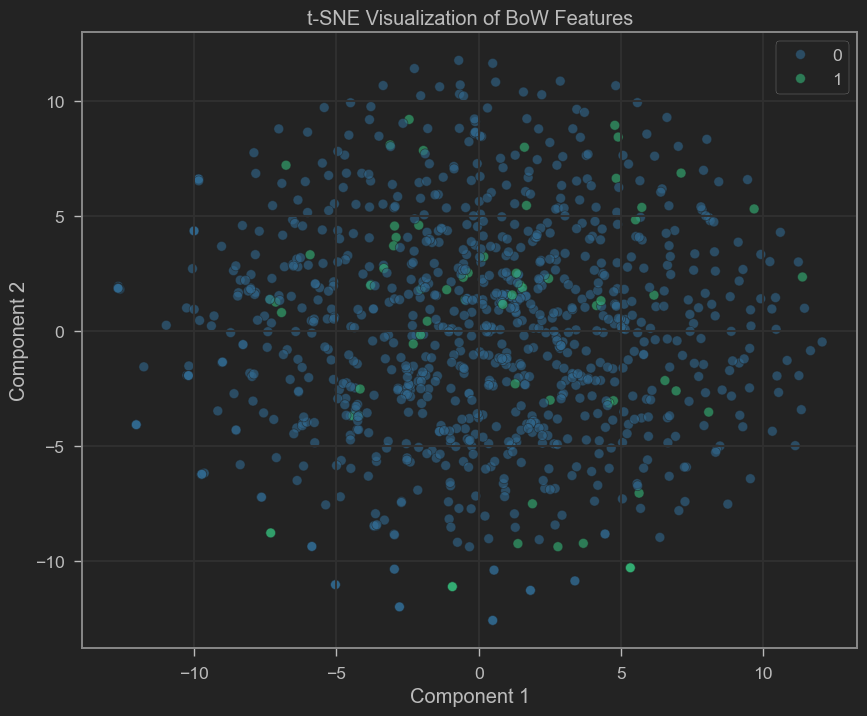

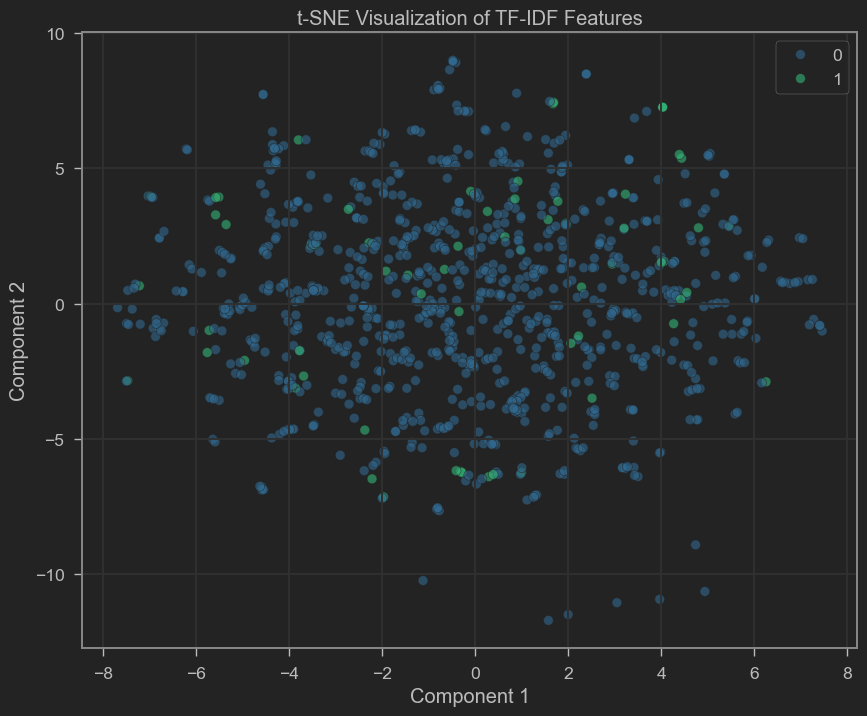

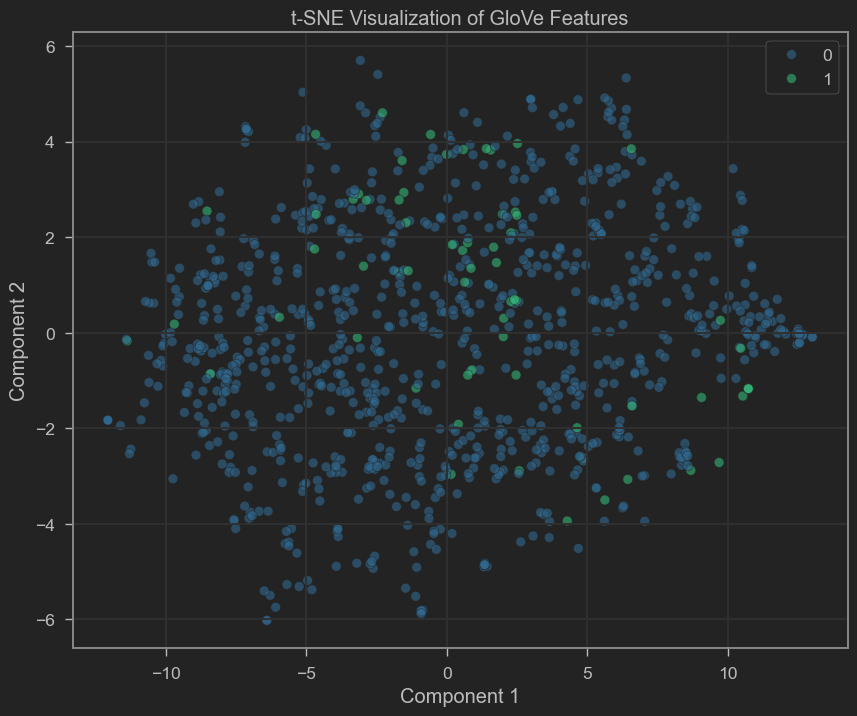

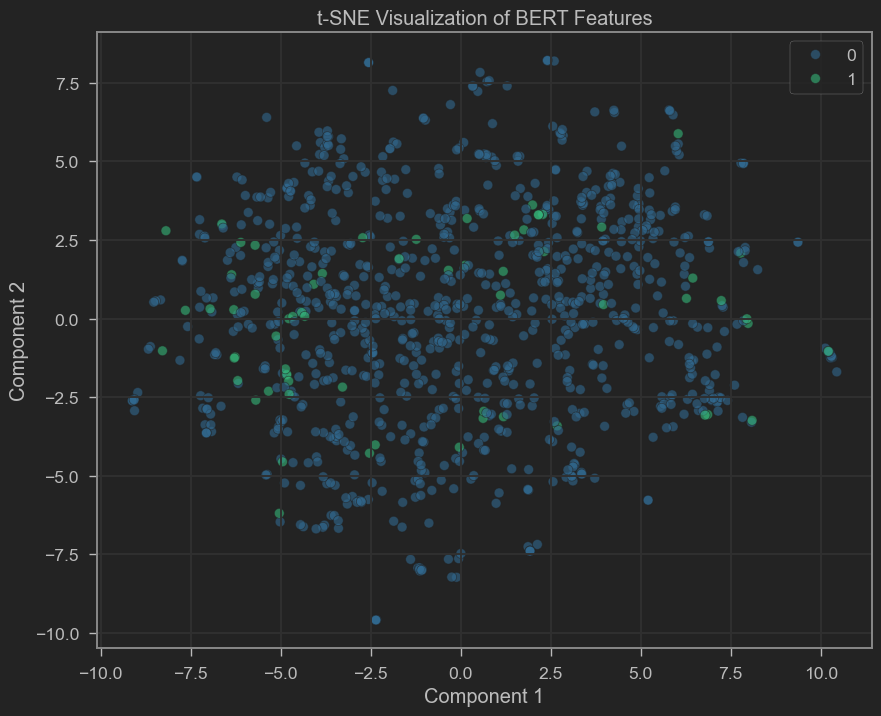

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import joblib

# Function to plot the embeddings
def plot_embeddings(embeddings, labels, title):
    plt.figure(figsize=(10, 8))
    sns.scatterplot(x=embeddings[:, 0], y=embeddings[:, 1], hue=labels, palette="viridis", s=50, alpha=0.6, edgecolor='k')
    plt.title(title)
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    plt.legend(loc='best')
    plt.show()

# Reduce dimensions using t-SNE
def tsne_reduce(X, n_components=2, perplexity=30, random_state=42):
    tsne = TSNE(n_components=n_components, perplexity=perplexity, random_state=random_state, n_iter=300)
    return tsne.fit_transform(X)

# Load the saved feature representations
X_bow = joblib.load('./Embeddings/X_bow.pkl').todense()
X_tfidf = joblib.load('./Embeddings/X_tfidf.pkl').todense()
X_glove = np.load('./Embeddings/X_glove.npy')
X_bert = np.load('./Embeddings/X_bert.npy')
#X_gpt = np.load('./Embeddings/X_gpt.npy')

# Use the first 1000 samples to speed up t-SNE computation
sample_size = 1000
indices = np.random.choice(X_bow.shape[0], sample_size, replace=False)

# Sample labels
labels = np.array(train_labels)[indices]

# Apply t-SNE on the feature representations
X_bow_tsne = tsne_reduce(np.asarray(X_bow)[indices])
X_tfidf_tsne = tsne_reduce(np.asarray(X_tfidf)[indices])
X_glove_tsne = tsne_reduce(X_glove[indices])
X_bert_tsne = tsne_reduce(X_bert[indices])
#X_gpt_tsne = tsne_reduce(X_gpt[indices])

# Plot the t-SNE results
plot_embeddings(X_bow_tsne, labels, title="t-SNE Visualization of BoW Features")
plot_embeddings(X_tfidf_tsne, labels, title="t-SNE Visualization of TF-IDF Features")
plot_embeddings(X_glove_tsne, labels, title="t-SNE Visualization of GloVe Features")
plot_embeddings(X_bert_tsne, labels, title="t-SNE Visualization of BERT Features")
#plot_embeddings(X_gpt_tsne, labels, title="t-SNE Visualization of GPT Features")


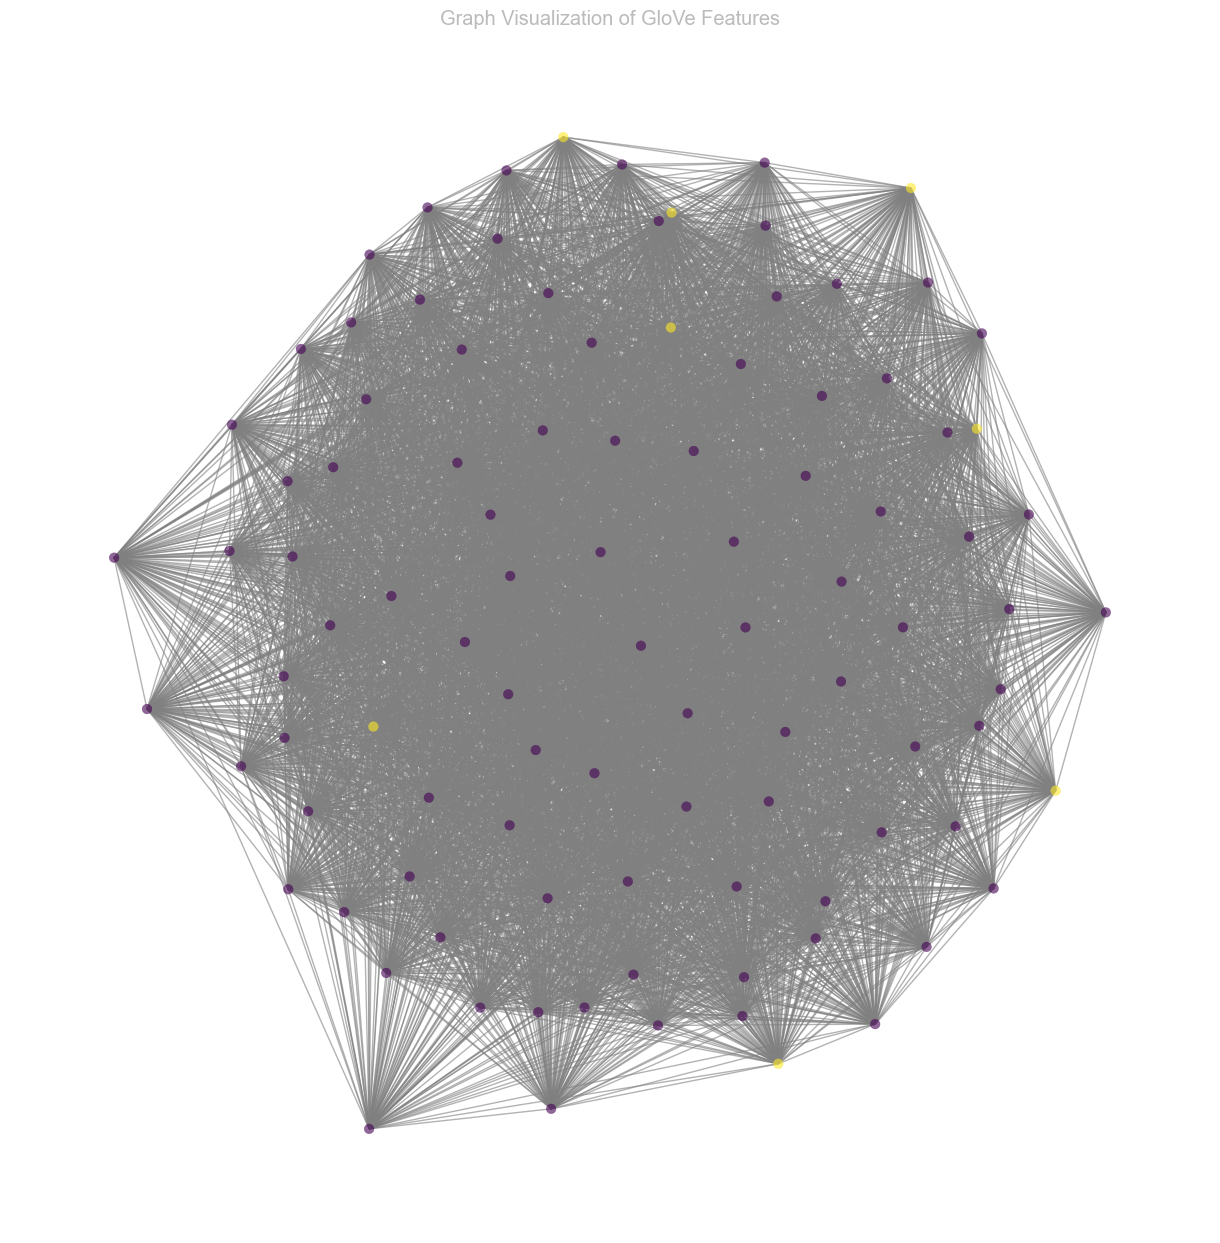

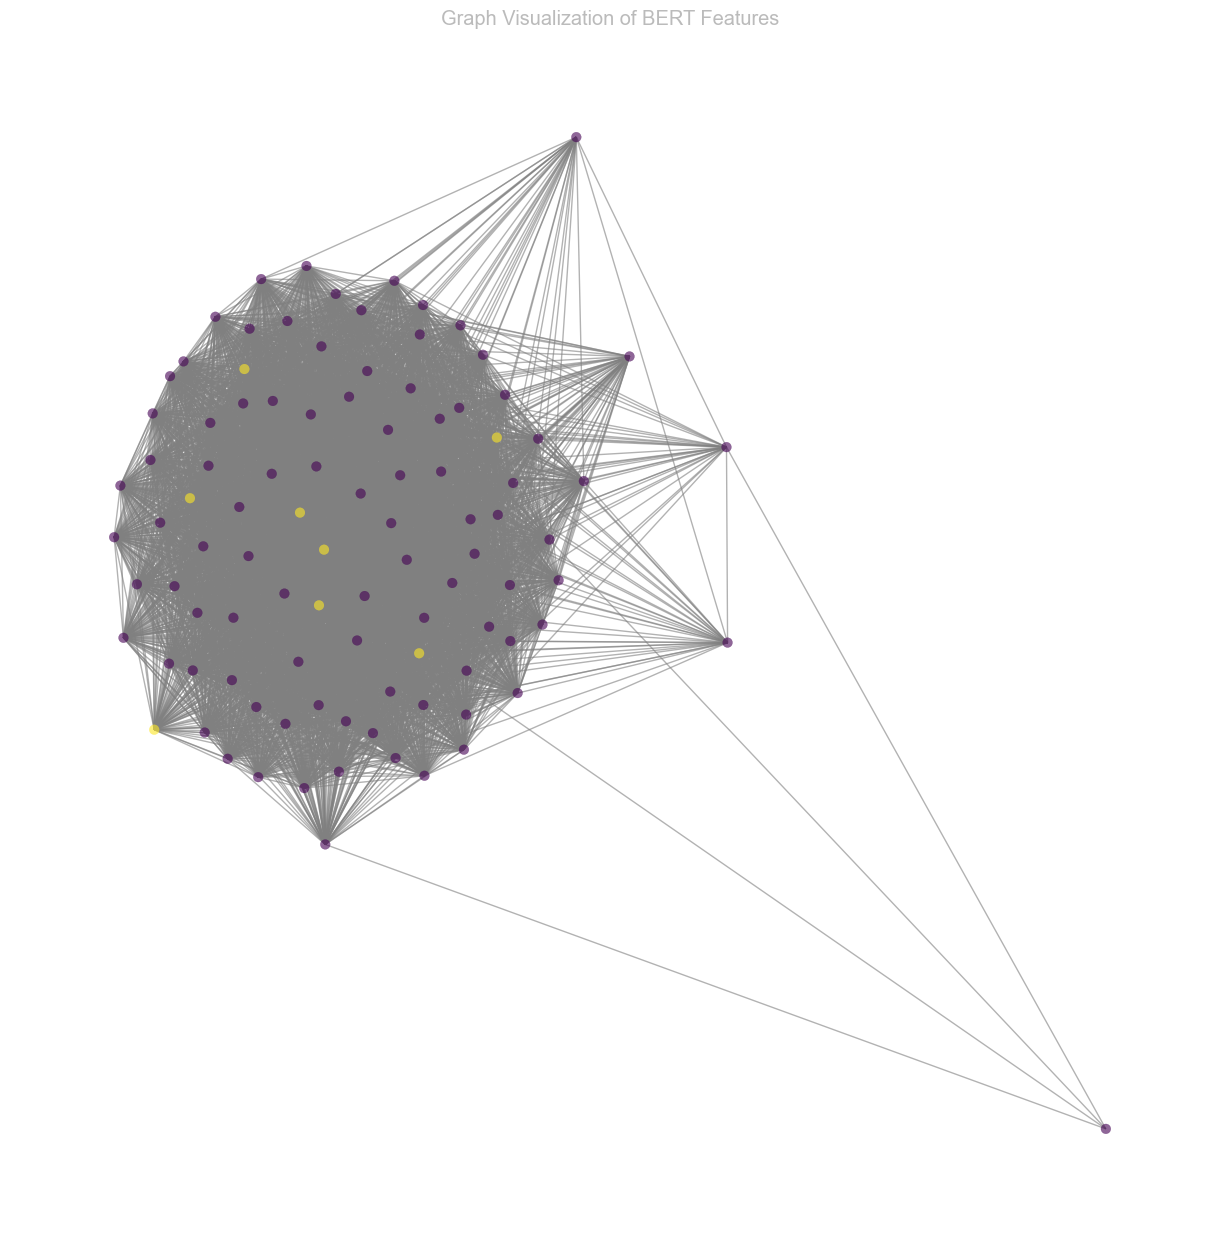

In [28]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
import joblib

# Convert feature representations to dense format if necessary
X_bow = np.asarray(joblib.load('./Embeddings/X_bow.pkl').todense())
X_tfidf = np.asarray(joblib.load('./Embeddings/X_tfidf.pkl').todense())
X_glove = np.load('./Embeddings/X_glove.npy')
X_bert = np.load('./Embeddings/X_bert.npy')
#X_gpt = np.load('./Embeddings/X_gpt.npy')

# Select a subset of data for visualization
sample_size = 100
indices = np.random.choice(X_bow.shape[0], sample_size, replace=False)

# Create a similarity matrix using cosine similarity
def create_similarity_matrix(X):
    return cosine_similarity(X)

# Build a graph from the similarity matrix
def build_graph(similarity_matrix, threshold=0.5):
    G = nx.Graph()
    num_nodes = similarity_matrix.shape[0]
    
    for i in range(num_nodes):
        for j in range(i + 1, num_nodes):
            if similarity_matrix[i, j] > threshold:
                G.add_edge(i, j, weight=similarity_matrix[i, j])
    
    return G

# Plot the graph using NetworkX
def plot_graph(G, labels, title):
    plt.figure(figsize=(12, 12))
    pos = nx.spring_layout(G, seed=42)
    nx.draw(G, pos, node_color=[labels[node] for node in G.nodes()], 
            node_size=50, cmap=plt.cm.viridis, with_labels=False, 
            edge_color="gray", alpha=0.6)
    plt.title(title)
    plt.show()

# Compute similarity matrices for each feature representation
similarity_matrix_bow = create_similarity_matrix(X_bow[indices])
similarity_matrix_tfidf = create_similarity_matrix(X_tfidf[indices])
similarity_matrix_glove = create_similarity_matrix(X_glove[indices])
similarity_matrix_bert = create_similarity_matrix(X_bert[indices])
#similarity_matrix_gpt = create_similarity_matrix(X_gpt[indices])

# Build graphs for each feature representation
G_bow = build_graph(similarity_matrix_bow)
G_tfidf = build_graph(similarity_matrix_tfidf)
G_glove = build_graph(similarity_matrix_glove)
G_bert = build_graph(similarity_matrix_bert)
#G_gpt = build_graph(similarity_matrix_gpt)

# Sample labels
labels = np.array(train_labels)[indices]

# Plot the graphs
#plot_graph(G_bow, labels, "Graph Visualization of BoW Features")
#plot_graph(G_tfidf, labels, "Graph Visualization of TF-IDF Features")
plot_graph(G_glove, labels, "Graph Visualization of GloVe Features")
plot_graph(G_bert, labels, "Graph Visualization of BERT Features")
#plot_graph(G_gpt, labels, "Graph Visualization of GPT Features")


### Comparative Analysis of GloVe and BERT Feature Representations

The graphs visualize the feature representations of tweets using GloVe and BERT embeddings. Each node represents a tweet, and edges represent similarity (cosine similarity) between tweets that exceed a specified threshold.

#### GloVe Feature Representations

- **Graph Density**: The graph for GloVe embeddings shows a relatively sparse connectivity, with many nodes having fewer connections. There are several clusters where nodes are tightly connected, indicating groups of tweets that share significant semantic similarities.
- **Clustering**: The presence of distinct clusters suggests that GloVe embeddings can capture some semantic relationships between words and tweets. However, the separation between clusters may not be very pronounced, indicating that GloVe embeddings might miss some contextual nuances.
- **Node Distribution**: Nodes are spread out more evenly across the graph. This even distribution suggests that GloVe embeddings tend to create more generalized feature representations, capturing the overall semantic similarity without deeply understanding the context.

#### BERT Feature Representations

- **Graph Density**: The graph for BERT embeddings is significantly denser, with many nodes interconnected. This high density indicates that BERT embeddings capture nuanced contextual information, making tweets appear more similar to each other in the embedding space.
- **Clustering**: There is a more pronounced clustering of nodes, showing that BERT embeddings can effectively capture and group tweets with similar contexts. This suggests that BERT's context-aware embeddings can better understand the relationships between tweets, even when the semantic similarity is subtle.
- **Node Distribution**: Nodes in the BERT graph are tightly packed within clusters, indicating a higher degree of similarity within clusters. This tight packing implies that BERT embeddings can distinguish finer details in the context, leading to more precise grouping of related tweets.

#### Summary

- **Semantic Understanding**:
  - **GloVe**: Captures general semantic relationships but may miss finer contextual details.
  - **BERT**: Provides a deeper understanding of context, capturing subtle nuances and leading to denser connectivity.
  
- **Clustering**:
  - **GloVe**: Forms more generalized clusters, with less distinct separation between them.
  - **BERT**: Creates tighter, more defined clusters, indicating better differentiation of contextually similar tweets.

- **Graph Density**:
  - **GloVe**: Sparser, indicating a broader but less nuanced semantic capture.
  - **BERT**: Denser, showing more detailed and context-aware relationships.

The comparative analysis highlights that while GloVe embeddings provide a good general semantic understanding, BERT embeddings offer a more sophisticated and context-aware representation, making them more suitable for tasks that require a deep understanding of the text context and nuances.

